In [1]:
#the difference between version 1 and 2 is that version 2 considers only 1 year before and after 

In [2]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import ast
from datetime import datetime

from global_functions import *

In [3]:
release_creation_ts_all = get_release_dates()

yearly_releases = get_yearly_releases()

release_creation_ts_rolling = get_rolling_releases()
rolling_releases=get_rolling_releases()

In [4]:
def version_successor(release):
    if release=='4.8':
        return '4.9'
    return yearly_releases[yearly_releases.index(release)+1]
def version_successor_rolling(release):
    if release=='4.10':
        return '4.11'
    return rolling_releases[rolling_releases.index(release)+1]
   
def version_predecessor(release):
    return yearly_releases[yearly_releases.index(release)-1]    
     
    

In [5]:
def attach_severity_priority_to_dataframe(df):
    sev_info = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_full.zip',index_col=False,compression='zip',
                      dtype={'version':str})
    sev_info = sev_info[['id','severity','priority']]

    df = pd.merge(df,sev_info,on=['id'],how='left')
    return df


In [6]:
#Load data
df_all = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.zip',index_col=False,compression='zip',dtype={'release':str,'version':str})
df_all = df_all.fillna('')
df_all = trans_to_datetime(df_all,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df_all=attach_severity_priority_to_dataframe(df_all)
df_all.head(n=2)

C:\Users\zeinab\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field,severity,priority
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False,normal,P3
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False,minor,P3


In [7]:
#all expect these in rolling releases
df=df_all[(df_all['release']!='4.9') & (df_all['release']!='4.10')]
#bugs in rolling release
df_rolling=df_all[(df_all['release']=='4.9') | (df_all['release']=='4.10')]

In [8]:
def get_triaging_statistics_per_release(df_w,assignedFirst,fixedLast):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if fixedLast:
        fix_column = 'first_fixed_date'
    else:
        fix_column = 'last_fixed_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        if version=='3.0':
            end_date_before=addYears(start_date,-1)
            #print(release_creation_ts_all[version_successor(version)])
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')
        else:
            end_date_before=datetime.strptime(release_creation_ts_all[version_predecessor(version)], '%Y-%m-%d %H:%M:%S')
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')                
        
        #print('version: ',version, 'start_date: ',start_date,'end_date_before: ',end_date_before,'end_date_after: ',end_date_after)

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column] >= start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[fix_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[fix_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA =  bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [9]:
tfile = 'data'+os.sep+'RQ2'+os.sep+'year_releases_yearly_stats_last_fix-v2.zip'

if not os.path.exists(tfile):
    df_yearly_stats_first = get_triaging_statistics_per_release(df,assignedFirst=True,fixedLast=False)
    df_yearly_stats_first.to_csv(tfile,index=False,compression='zip')
else:
    df_yearly_stats_first = pd.read_csv(tfile,index_col=False,compression='zip',
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first["RAAA"]  = df_yearly_stats_first["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAA"]  = df_yearly_stats_first["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAB"]  = df_yearly_stats_first["RBAB"].apply(ast.literal_eval)
    df_yearly_stats_first["RANA"]  = df_yearly_stats_first["RANA"].apply(ast.literal_eval)
    
df_yearly_stats_first['version'] = df_yearly_stats_first['version'].astype(str)
df_yearly_stats_first = sort_df(df_yearly_stats_first,'version')
df_yearly_stats_first.head()

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\zeinab\Papers\26-3-2019\msr2019\rep-pack\global_functions.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dd[col] = pd.to_datetime(dd[col])


,version,RAAA,RANA,RBAA,RBAB,after_release,before_release,total
0,3.0,"[82566, 82589, 82623, 82627, 82837, 83019, 831...","[101046, 82937, 83496, 84620, 80981, 81278, 81...","[64612, 64639, 64664, 64686, 64691, 64707, 647...","[64614, 64617, 64626, 64627, 64629, 64633, 646...",6534.0,17758.0,24937.0
1,3.1,"[102081, 102088, 102102, 102127, 102165, 10226...","[102192, 102440, 102570, 102686, 102699, 10276...","[100816, 100875, 100889, 100908, 100916, 10092...","[100822, 100823, 100825, 100829, 100867, 10092...",5264.0,12168.0,17908.0
2,3.2,"[187149, 187318, 187632, 188230, 179648, 18059...","[183675, 184345, 184932, 185216, 185561, 18682...","[103301, 103650, 103809, 104795, 139854, 13986...","[102324, 103299, 104892, 104902, 105132, 10524...",4771.0,10334.0,15834.0
3,3.3,"[237830, 223342, 223790, 224422, 224477, 22508...","[237612, 223233, 223475, 223857, 223956, 22434...","[183730, 183810, 183830, 183866, 183963, 18402...","[183596, 183599, 183607, 183610, 183621, 18362...",4141.0,8050.0,12642.0
4,3.4,"[244396, 244397, 244425, 244428, 244472, 24452...","[244409, 244757, 245388, 245601, 246505, 24976...","[236612, 236615, 236628, 236634, 236666, 23668...","[236669, 236844, 236922, 237034, 237106, 23713...",3908.0,7891.0,12510.0


In [10]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first.iterrows():
    #the bug created and assigned & before release  
   # print(type(row['RBAB']))
   # print(row['RBAB'])
    release=str(row['version'])
    
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    if len(df_b)>0:

            

        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])
        df_b['fixing_time'] =df_b.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:
   
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['fixing_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)
   
    #
traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-RB-v2.zip',compression='zip',index=False)    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-RA-v2.zip',compression='zip',index=False)

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

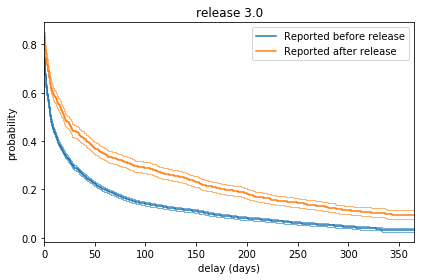

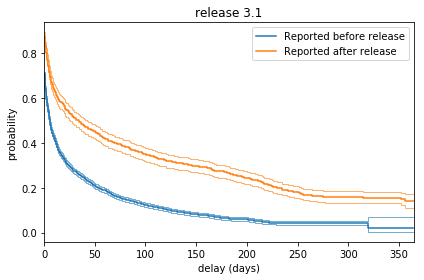

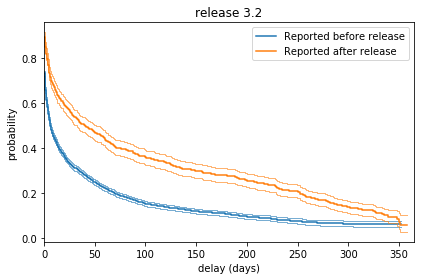

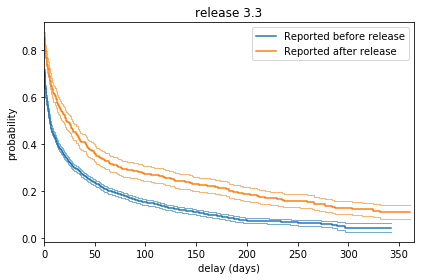

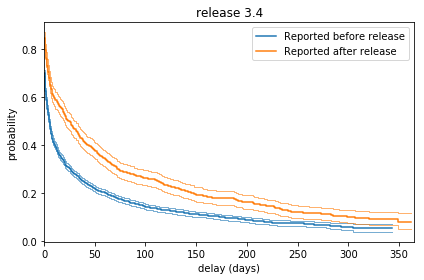

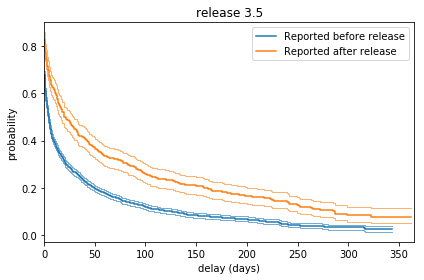

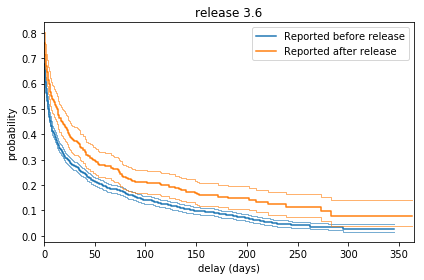

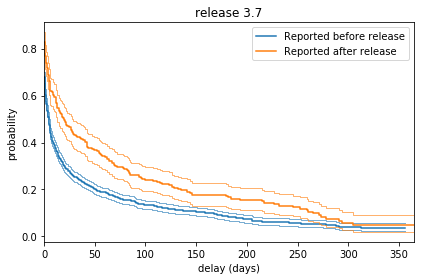

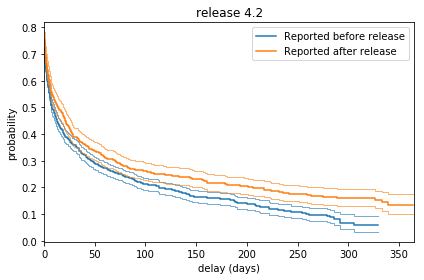

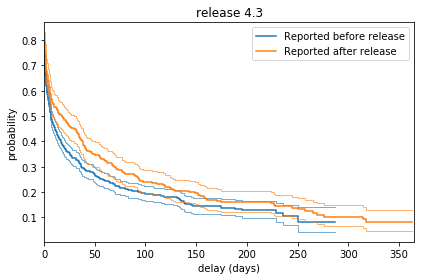

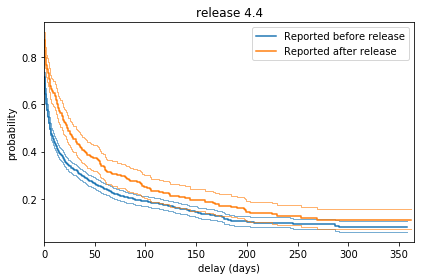

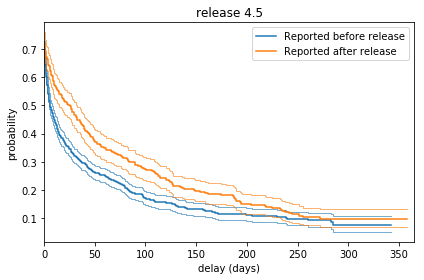

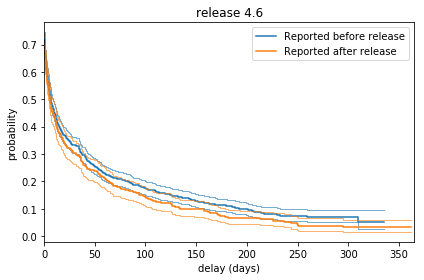

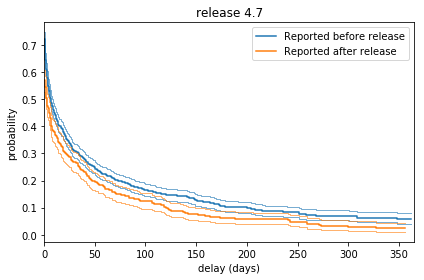

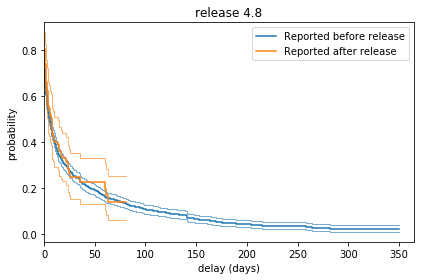

In [11]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-RB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-RA-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)
time=['Reported before release','Reported after release']

for release in RBAB.release.unique():
    ax = plt.subplot(1, 1,1)
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T = dat["fixing_time"]
            E = dat["done"]
            kmf.fit( T, E, label=time[j-1])
            kmf.plot(ax=ax, ci_force_lines=True)
            ax.set_xlabel("delay (days)")
            ax.set_ylabel("probability")
 
    plt.title('release '+version)
    plt.xlim(0, 365)

    plt.savefig('../paper/figs/RQ2/survivalFix_'+version.replace('.', '_')+'.pdf')
    
    plt.tight_layout( )
    plt.show()


In [12]:
#logrank test

In [13]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-RB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'fix-Eclipse-RA-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 7
for release in RBAB.release.unique():
    i=0
    
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    k=0
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T[k] = dat["fixing_time"]
            E[k] = dat["done"]
            k=k+1
    results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
    pDat=pd.DataFrame({'version': [release] , 'p':[results[i]] })

    #print(version)
    pData=pData.append(pDat)
 


In [14]:
pData= pData[['version' , 'p']]
pData

,version,p
0,3.0,8.482007e-41
0,3.1,1.814600e-70
0,3.2,9.976269e-43
0,3.3,1.892517e-22
0,3.4,5.241206e-21
0,3.5,1.734104e-20
0,3.6,7.676153e-06
0,3.7,1.360518e-08
0,4.2,4.929087e-04
0,4.3,4.729573e-03


In [15]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')

In [16]:
pData

,version,p,H0
0,3.0,8.482007e-41,reject H0
0,3.1,1.814600e-70,reject H0
0,3.2,9.976269e-43,reject H0
0,3.3,1.892517e-22,reject H0
0,3.4,5.241206e-21,reject H0
0,3.5,1.734104e-20,reject H0
0,3.6,7.676153e-06,reject H0
0,3.7,1.360518e-08,reject H0
0,4.2,4.929087e-04,reject H0
0,4.3,4.729573e-03,reject H0


In [17]:
pData.to_csv('data'+os.sep+'RQ2'+os.sep+'fix-logrank_test-v2.zip',index=False,compression='zip')

# rolling release

In [18]:
      temp_rolling={  "4.9"  : "2018-09-19 00:00:00",
        "4.10" : "2018-12-19 00:00:00",
        "4.11" : "2019-03-20 00:00:00"}

In [19]:
def get_triaging_statistics_per_release_rolling(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        fix_column = 'first_fixed_date'
    else:
        fix_column = 'last_fixed_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        
        end_date_before=addYears(start_date,-1)
        end_date_after=datetime.strptime(temp_rolling[version_successor_rolling(version)], '%Y-%m-%d %H:%M:%S')

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[fix_column] > start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[fix_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[fix_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA = bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [20]:
tfile = 'data'+os.sep+'RQ2'+os.sep+'rolling_releases_yearly_stats_last_fix-v2.zip'
if not os.path.exists(tfile):
    df_yearly_stats_first_rolling = get_triaging_statistics_per_release_rolling(df_rolling,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first_rolling.to_csv(tfile,index=False,compression='zip')
else:
    df_yearly_stats_first_rolling = pd.read_csv(tfile,index_col=False,compression='zip',
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first_rolling["RAAA"]  = df_yearly_stats_first_rolling["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBAA"]  = df_yearly_stats_first_rolling["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBAB"]  = df_yearly_stats_first_rolling["RBAB"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RANA"]  = df_yearly_stats_first_rolling["RANA"].apply(ast.literal_eval)
    
df_yearly_stats_first_rolling['version'] = df_yearly_stats_first_rolling['version'].astype(str)
df_yearly_stats_first_rolling = sort_df(df_yearly_stats_first_rolling,'version')
df_yearly_stats_first_rolling.head()

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,version,RAAA,RANA,RBAA,RBAB,after_release,before_release,total
0,4.9,"[539232, 539274, 539308, 539331, 539392, 53940...","[539414, 539706, 539707, 539869, 540817, 54247...","[539164, 539167, 539191, 536193, 536393, 53695...","[539197, 535977, 535992, 536027, 536028, 53606...",341.0,392.0,791.0
1,4.10,"[542946, 543219, 543245, 543609, 543629, 54364...",[],"[540478, 540482, 540675, 541025, 541119, 54120...","[540026, 540083, 540097, 540118, 540124, 54020...",179.0,389.0,572.0


In [21]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first_rolling.iterrows():
    #the bug created and assigned & before release  
   # print(type(row['RBAB']))
   # print(row['RBAB'])
    release=str(row['version'])
    
    #print(release)
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    #print(len(df_b))
    if len(df_b)>0:
 
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])
        df_b['fixing_time'] =df_b.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:

   
        df_b=trans_to_datetime(df_b,['creation_time','last_fixed_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['fixing_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'last_fixed_date',
         'fixing_time' ,'release' ]]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (x['last_fixed_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor_rolling(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','last_fixed_date']) 
        df_a['fixing_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'last_fixed_date',
         'fixing_time',
            'release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)
   
    #
traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-RB-v2.zip',index=False,compression='zip')    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-RA-v2.zip',index=False,compression='zip')

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

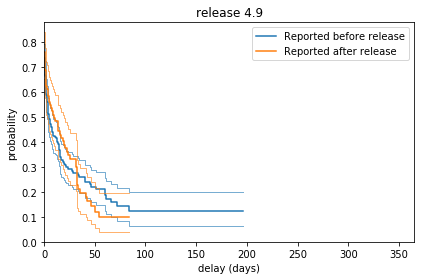

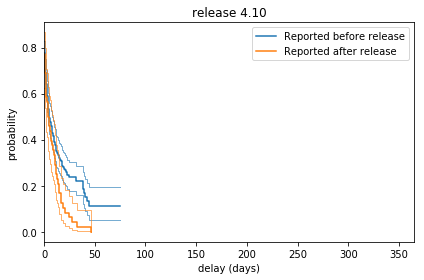

In [22]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-RB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-RA-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)
time=['Reported before release','Reported after release']

for release in RBAB.release.unique():
    ax = plt.subplot(1, 1,1)
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T = dat["fixing_time"]
            E = dat["done"]
            kmf.fit( T, E, label=time[j-1])
            kmf.plot(ax=ax, ci_force_lines=True)
            ax.set_xlabel("delay (days)")
            ax.set_ylabel("probability")
 
    plt.title('release '+version)
    plt.xlim(0, 365)

    plt.savefig('../paper/figs/RQ2/survivalFix_'+version.replace('.', '_')+'.pdf')
    
    plt.tight_layout( )
    plt.show()


In [23]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-RB-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_fix-Eclipse-RA-v2.zip',index_col=False,compression='zip',dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 7
for release in RBAB.release.unique():
    i=0
    
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    k=0
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T[k] = dat["fixing_time"]
            E[k] = dat["done"]
            k=k+1
    results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
    pDat=pd.DataFrame({'version': [release] , 'p':[results[i]] })

    #print(version)
    pData=pData.append(pDat)
 


In [24]:
pData= pData[['version' , 'p']]
pData

,version,p
0,4.9,0.968796
0,4.10,0.012782


In [25]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')

In [26]:
pData

,version,p,H0
0,4.9,0.968796,can not reject H0
0,4.10,0.012782,can not reject H0
